# Support Vector Machines (SVM) using Scikit-Learn

**Author**:Sarvin


This Jupyter Notebook provides examples on how to load the data sets and perform a simple machine learning classification task.

We will be using different modelling techniques such as:

* Deep Neural Network
* Simple Vector Machine
* Linear SVC
* NU SVC

# Load the data set

We begin by importing a few essential libraries and then loading one of the data sets.

In [2]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The data set is available in two formats: ROOT and HDF5. In this example we are using ROOT.
The uproot package can be used to read a .root file to Python without having to necessarily install the whole ROOT software.

In [3]:
# Load a ROOT file
filePath='../files/JetNtuple_RunIISummer16_13TeV_MC_1_skimmed.root'
tree = uproot.open(filePath)['jetTree']



In [4]:
# Create and fill a dataframe
df = pd.DataFrame()
remaining_vars = []


Creating Flags for different modelling techniques such as Deep Neural Network, Simple Vector Machine, Linear SVC and NU SVC make it easier to compare the result.

In [5]:
PLOT = True
DO_DNN = True
DO_SVM = True 
VERBOSE = False
DO_Lin = True
DO_Nu  = True 

# Classification Quark/gluon jet

This machine learning example is the classification of jets originating either from gluons or the three of the lightest quarks (up, down and strange). This is an important task, since on the observable macroscopic level the two types of jets look very similar, but from a physical point of view the difference between them is significant.



In [6]:
for key in tree.keys():
   
   #TO-DO: Figure out how to accomodate awkward arrays
   if str(type(tree[key].array()[0])) != "<class 'awkward.highlevel.Array'>":
      df[key] = np.array(tree[key].array())
   else:
      remaining_vars.append(key)
   pass

if VERBOSE:   
   print("Remaining variables not accounted for:")
   print(remaining_vars)

# First remove all the other types of jets from the data except the gluon and the light quark (UDS) jets
df = df[(df.isPhysG==1) | (df.isPhysUDS==1)].reset_index()

if VERBOSE:   
   print(df)

From left to right these variables are the **jet multiplicity (QG_mult)**, the **jet momentum distribution variable (QG_ptD)** and the **jet minor axis (QG_axis2)**. The distributions display statistical differences between the two types of jets.

**Jet multiplicity** is the number of particles contained in the jet (subject to certain constraints on the properties of the particles, see CMS-PAS-JME-13-002 again). Gluons are expected to radiate more intensely, so on average gluon jets contain more particles.

**The jet momentum distribution variable** describes how the **total transverse momentum** of a jet is distributed to its constituents. Quark jets are expected to have fewer constituents carrying the majority of the jet's momentum, which means that the value of the jet momentum distribution is on average larger for quark jets.

**The jet minor axis** describes the width of the jet when it is approximated as an ellipse. Gluon jets are on average wider than quark jets.



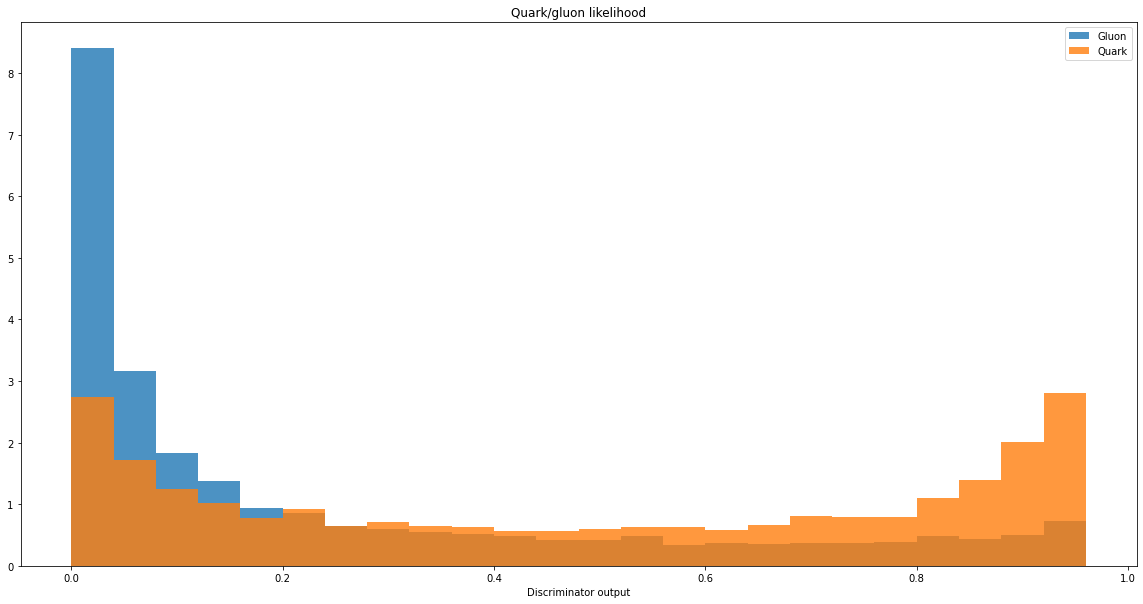

In [7]:
if PLOT:
   
   hist_columns = ['QG_mult','QG_ptD','QG_axis2']
   binnings = [np.arange(0,70,2), np.arange(0.0,1.0,0.04), np.arange(0.0,0.2,0.01)]

   ind = 0
   fig, axes = plt.subplots(1, 3, figsize=(20,10))

   for column in hist_columns:
      axes[ind].hist( df[df.isPhysG==1][column], bins=binnings[ind], alpha=0.8, label='Gluon', density=1 )
      axes[ind].hist( df[df.isPhysUDS==1][column], bins=binnings[ind], alpha=0.8, label='Quark', density=1 )
      axes[ind].set_xlabel(column)
      axes[ind].legend()
      ind = ind+1

   plt.savefig("./ML_vars.png")
   plt.clf()

   binning = np.arange(0.0, 1.0, 0.04)
   plt.hist( df[df.isPhysG==1]['jetQGl'], bins=binning, alpha=0.8, label='Gluon', density=1 )
   plt.hist( df[df.isPhysUDS==1]['jetQGl'], bins=binning, alpha=0.8, label='Quark', density=1 )
   plt.legend()
   plt.xlabel('Discriminator output')
   plt.title('Quark/gluon likelihood')

   plt.savefig("./ML_QGL.png")


Our target output is the isPhysUDS column, the value of which is one for light quark jets and zero for gluon jets. Hence the output will be similar to the likelihood discriminator, allowing us to directly compare their performance.

Then we choose the input features for the modelling techniques. In addition to the three variables, let's add the transverse momentum of the jet (**jetPT**) and the pseudorapidity of the jet (**jetEta**). 

We will also perform some basic preprocessing in the form of normalizing the input features by columnwise subtraction of the mean and division by the standard deviation.

In [8]:
#
# Preprocessing
#

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

test_y = test.isPhysUDS

input_features = ['jetPt', 'jetEta', 'QG_mult', 'QG_ptD', 'QG_axis2']

if DO_SVM:

   train_x_svm = train[input_features]
   train_y_svm = train.isPhysUDS

   test_x_svm = test[input_features]
   test_y_svm = test.isPhysUDS

   train_x_mean_svm = train_x_svm.mean()
   train_x_std_svm = train_x_svm.std()

   train_x_svm = (train_x_svm - train_x_mean_svm) / train_x_std_svm
   test_x_svm = (test_x_svm - train_x_mean_svm) / train_x_std_svm

if DO_DNN:

   train_y_dnn = train.isPhysUDS
   test_y_dnn = test.isPhysUDS


   train_x_dnn = train[input_features]
   test_x_dnn = test[input_features]

   # Normalize the features
   train_x_mean_dnn = train_x_dnn.mean()
   train_x_std_dnn = train_x_dnn.std()

   train_x_dnn = (train_x_dnn - train_x_mean_dnn) / train_x_std_dnn
   test_x_dnn = (test_x_dnn - train_x_mean_dnn) / train_x_std_dnn


if DO_Lin:

   train_x_lin = train[input_features]
   train_y_lin = train.isPhysUDS

   test_x_lin = test[input_features]
   test_y_lin = test.isPhysUDS

   train_x_mean_lin = train_x_lin.mean()
   train_x_std_lin = train_x_lin.std()

   train_x_lin = (train_x_lin - train_x_mean_lin) / train_x_std_lin
   test_x_lin = (test_x_lin - train_x_mean_lin) / train_x_std_lin

if DO_Nu:

   train_x_nu = train[input_features]
   train_y_nu = train.isPhysUDS

   test_x_nu = test[input_features]
   test_y_nu = test.isPhysUDS

   train_x_mean_nu = train_x_nu.mean()
   train_x_std_nu = train_x_nu.std()

   train_x_nu = (train_x_nu - train_x_mean_nu) / train_x_std_nu
   test_x_nu = (test_x_nu - train_x_mean_nu) / train_x_std_nu




We are ready to build and train our model.

In [9]:
if DO_DNN:

   import tensorflow as tf
   import keras.backend as K

   sess = tf.compat.v1.Session()
   tf.compat.v1.keras.backend.set_session(sess)

   from keras.models import Model, Sequential
   from keras.layers import Input, Dense, Dropout
   from sklearn.utils import class_weight

   # Define the DNN architecture
   model = Sequential()
   model.add(Dense(64, kernel_initializer='normal', activation='relu', input_dim=train_x_dnn.shape[1]))
   model.add(Dropout(0.2))
   model.add(Dense(64, kernel_initializer='normal', activation='relu'))
   model.add(Dropout(0.2))
   model.add(Dense(32, kernel_initializer='normal', activation='relu'))
   model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
   model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])
   
 #Weight the training samples so that there is equal weight on gluon and quark jets
 #even if there are different amount of them in the training set
   
class_weights = class_weight.compute_class_weight(
                                                      class_weight = 'balanced', 
                                                      classes = np.unique(train_y_dnn), 
                                                      y = train_y_dnn
                                                    )
                                                      
class_weights = dict(zip(np.unique(train_y_dnn), class_weights))

# Train the model
model.fit(train_x_dnn,           
             train_y_dnn,
             epochs=20,
             batch_size=128,
             class_weight=class_weights,
             validation_split=0.2,
             shuffle=True,
             verbose=1);
    
    

2021-12-30 12:06:02.865017: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-30 12:06:02.868673: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.



Epoch 1/20


2021-12-30 12:06:03.315689: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-12-30 12:06:03.452389: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


70/70 [==============================] - 9s 106ms/step - loss: 0.6072 - accuracy: 0.7258 - val_loss: 0.5307 - val_accuracy: 0.7327
Epoch 2/20
70/70 [==============================] - 8s 110ms/step - loss: 0.5365 - accuracy: 0.7382 - val_loss: 0.5244 - val_accuracy: 0.7390
Epoch 3/20
70/70 [==============================] - 7s 100ms/step - loss: 0.5297 - accuracy: 0.7447 - val_loss: 0.5147 - val_accuracy: 0.7489
Epoch 4/20
70/70 [==============================] - 6s 87ms/step - loss: 0.5269 - accuracy: 0.7481 - val_loss: 0.5226 - val_accuracy: 0.7489
Epoch 5/20
70/70 [==============================] - 7s 98ms/step - loss: 0.5234 - accuracy: 0.7503 - val_loss: 0.5009 - val_accuracy: 0.7583
Epoch 6/20
70/70 [==============================] - 6s 91ms/step - loss: 0.5232 - accuracy: 0.7487 - val_loss: 0.5109 - val_accuracy: 0.7516
Epoch 7/20
70/70 [==============================] - 7s 106ms/step - loss: 0.5213 - accuracy: 0.7510 - val_loss: 0.5089 - val_accuracy: 0.7579
Epoch 8/20
70/70 [==

By reating predictions for the test set and plotting the classifier output we can  see how the trained model performs.

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


<Figure size 432x288 with 0 Axes>

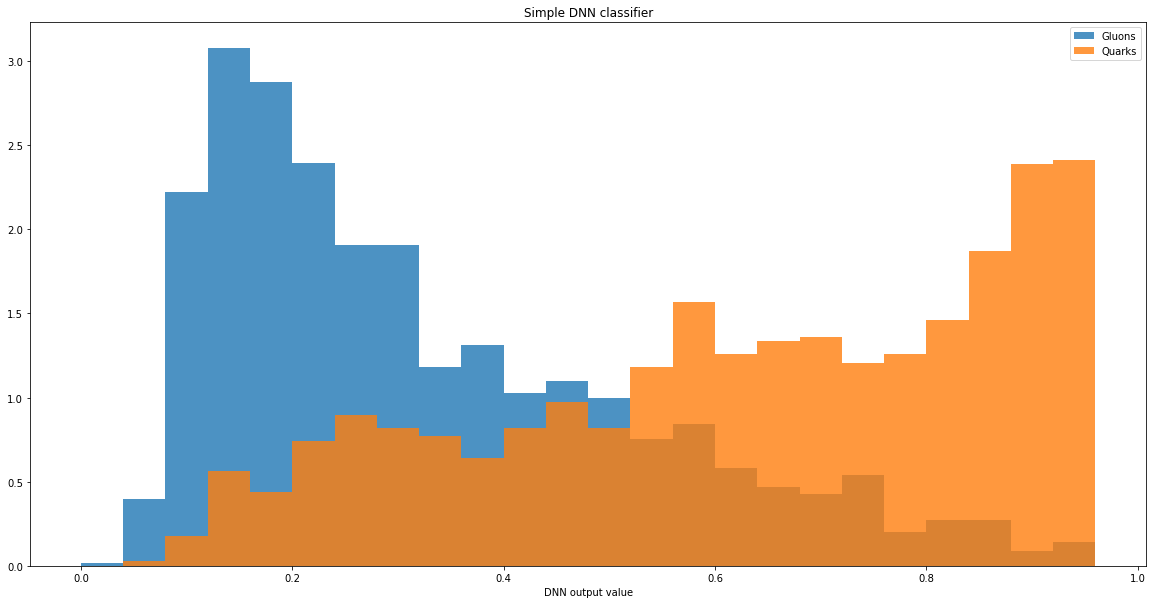

In [11]:


pred_y_dnn = model.predict(test_x_dnn)

if DO_SVM:

   from sklearn.svm import SVC

   clf = SVC(kernel="poly", random_state=42).fit(train_x_svm, train_y_svm)

   pred_y_svm = clf.decision_function(test_x_svm)

if PLOT and DO_DNN:

   plt.clf()
   binning = np.arange(0.0, 1.0, 0.04)
   plt.figure( figsize=(20,10))
   plt.hist( pred_y_dnn[test_y_dnn==0], bins=binning, alpha=0.8, label="Gluons", density=1 )
   plt.hist( pred_y_dnn[test_y_dnn==1], bins=binning, alpha=0.8, label="Quarks", density=1 )
   plt.legend()
   plt.xlabel('DNN output value')
   plt.title('Simple DNN classifier')
   plt.savefig("ML_DNNClassifier.png")

if DO_Lin:

   from sklearn.svm import LinearSVC

   clf = LinearSVC(loss="hinge", random_state=42).fit(train_x_lin, train_y_lin)

   pred_y_lin = clf.decision_function(test_x_lin)  

if DO_Nu:
    
    from sklearn.svm import NuSVC
   
    pred_y_nu = clf.decision_function(test_x_nu)   

In order to fairly compare our newly trained model and the traditional likelihood discriminator, we should look at the corresponding receiver operating characteristic (ROC) curves. The larger the area under the curve (AUC), the better the performance of the classifier.

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

if DO_DNN:
   fpr_dnn, tpr_dnn, thresholds_dnn  = roc_curve(test_y_dnn, pred_y_dnn)
   roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

if DO_SVM:
   fpr_svm, tpr_svm, thresholds_svm  = roc_curve(test_y_svm, pred_y_svm)
   roc_auc_svm = auc(fpr_svm, tpr_svm)

if DO_Lin:
   fpr_lin, tpr_lin, thresholds_lin  = roc_curve(test_y_lin, pred_y_lin)
   roc_auc_lin = auc(fpr_lin, tpr_lin) 

if DO_Nu:
   fpr_nu, tpr_nu, thresholds_nu  = roc_curve(test_y_nu, pred_y_nu)
   roc_auc_nu = auc(fpr_lin, tpr_nu)      

fpr_qgl, tpr_qgl, thresholds_qgl = roc_curve(test_y, test.jetQGl)
roc_auc_qgl = auc(fpr_qgl, tpr_qgl)


Here we can compare the AUC of the different modelling techniques and see which have the better performance of the classifier.

<Figure size 432x288 with 0 Axes>

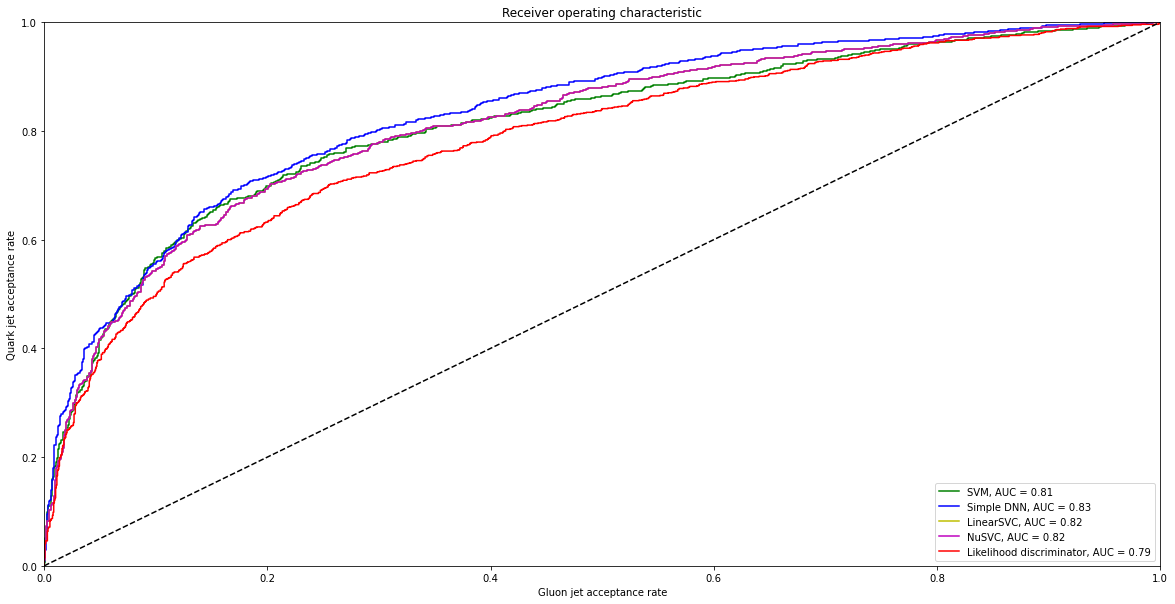

In [13]:
if PLOT:

   plt.clf()
   plt.figure( figsize=(20,10)) 
   if DO_SVM: plt.plot(fpr_svm, tpr_svm, 'g', label='SVM, AUC = %0.2f'% roc_auc_svm)
   if DO_DNN: plt.plot(fpr_dnn, tpr_dnn, 'b', label='Simple DNN, AUC = %0.2f'% roc_auc_dnn)
   if DO_Lin: plt.plot(fpr_lin, tpr_lin, 'y', label='LinearSVC, AUC = %0.2f'% roc_auc_lin)
   if DO_Nu: plt.plot(fpr_nu, tpr_nu, 'm', label='NuSVC, AUC = %0.2f'% roc_auc_nu)
   plt.plot(fpr_qgl, tpr_qgl, 'r', label='Likelihood discriminator, AUC = %0.2f'% roc_auc_qgl)
   plt.plot([0,1], [0,1], 'k--')
   plt.xlim([0.0, 1.0])
   plt.ylim([0.0, 1.0])
   plt.legend(loc = 'lower right')
   plt.title("Receiver operating characteristic")
   plt.ylabel('Quark jet acceptance rate')
   plt.xlabel('Gluon jet acceptance rate');
   plt.savefig("SVM New.png")